<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/GGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

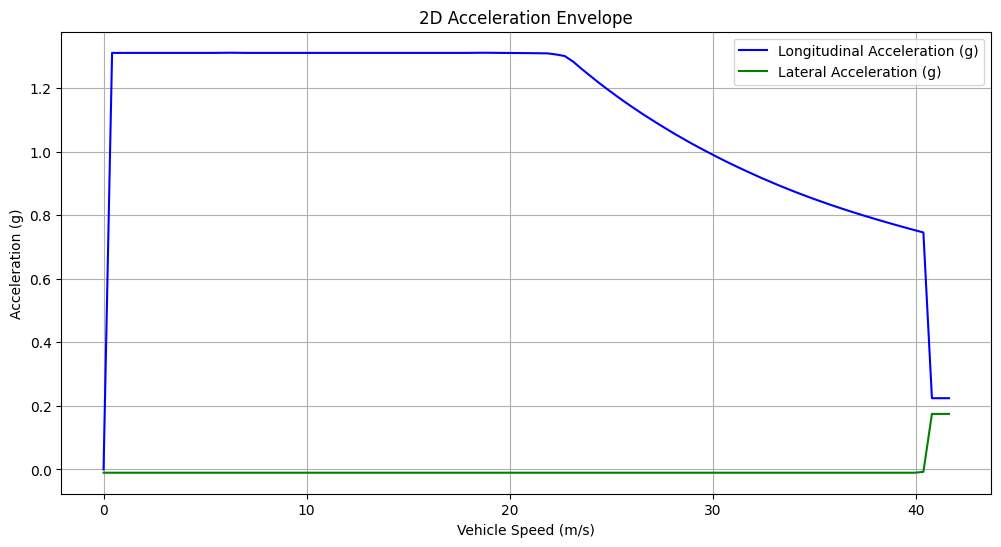

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constants
vehicle_mass_kg = 241  # Vehicle mass in kg
g = 9.81  # Acceleration due to gravity in m/s^2
tire_radius_m = 0.2629  # Tire radius in meters for Hoosier R25B 20.5 x 7.0-13
gear_ratio = 3.54  # Gear ratio from your Python code

# Load the datasets
tire_data = pd.read_csv('B1320run125.csv', skiprows=[1])
motor_data = pd.read_csv('MotorPower.csv')

# Create interpolation functions for torque and power
torque_interp = interp1d(motor_data['Motor Speed (RPM)'], motor_data['Torque (Capped at 80kW) (Nm)'],
                         bounds_error=False, fill_value="extrapolate")
power_interp = interp1d(motor_data['Motor Speed (RPM)'],
                        motor_data['Torque (Capped at 80kW) (Nm)'] * motor_data['Motor Speed (RPM)'] * 2 * np.pi / 60,
                        bounds_error=False, fill_value="extrapolate")

# Prepare arrays to hold acceleration values
speed_range = np.linspace(0, tire_data['V'].max(), 100)  # Speed range from tire data
long_acc = np.zeros_like(speed_range)
lat_acc = np.zeros_like(speed_range)

# Calculate the traction force available at each speed point
for i, speed in enumerate(speed_range):
    engine_rpm = speed / (2 * np.pi * tire_radius_m) * 60 * gear_ratio
    if engine_rpm >= motor_data['Motor Speed (RPM)'].min() and engine_rpm <= motor_data['Motor Speed (RPM)'].max():
        engine_torque = torque_interp(engine_rpm)
        wheel_torque = engine_torque * gear_ratio
        traction_force = wheel_torque / tire_radius_m
        long_acc[i] = traction_force / vehicle_mass_kg / g

    # Interpolating lateral force data
    lat_force = np.interp(speed, tire_data['V'], tire_data['FY'])
    lat_acc[i] = lat_force / vehicle_mass_kg / g

# Normalize long_acc within the bounds of tire data
max_long_force = np.interp(speed_range, tire_data['V'], tire_data['FX'])
max_long_acc = max_long_force / vehicle_mass_kg / g
long_acc = np.clip(long_acc, -max_long_acc, max_long_acc)

# 2D plot for lateral and longitudinal acceleration
plt.figure(figsize=(12, 6))
plt.plot(speed_range, long_acc, label='Longitudinal Acceleration (g)', color='blue')
plt.plot(speed_range, lat_acc, label='Lateral Acceleration (g)', color='green')
plt.title('2D Acceleration Envelope')
plt.xlabel('Vehicle Speed (m/s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit


data = pd.read_csv('B1320run54.csv', skiprows=[1])

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def get_max_grip_by_velocity(data, load_bin):
    max_grip_by_velocity = {}
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SA']
        y_data = group['FY']

        # Ensure there are enough data points for fitting
        if len(x_data) <= 5:  # Number of parameters in the model + 1
            print(f"Not enough data points for velocity {velocity}.")
            continue

        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            print(f"Curve fitting failed for velocity {velocity} with error: {e}")

    return max_grip_by_velocity


# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results = get_max_grip_by_velocity(data, load_bin)
print(max_grip_results)


Not enough data points for velocity 39.46.
Not enough data points for velocity 39.47.
Not enough data points for velocity 39.49.
Not enough data points for velocity 39.5.
Not enough data points for velocity 39.51.
Not enough data points for velocity 39.52.
Not enough data points for velocity 39.53.
Not enough data points for velocity 39.55.
Not enough data points for velocity 39.56.
Not enough data points for velocity 39.57.
Not enough data points for velocity 39.59.
Not enough data points for velocity 39.62.
Not enough data points for velocity 39.63.
Not enough data points for velocity 39.65.
Not enough data points for velocity 39.66.
Not enough data points for velocity 39.67.
Not enough data points for velocity 39.68.
Not enough data points for velocity 39.69.
Not enough data points for velocity 39.7.
Not enough data points for velocity 39.71.
Not enough data points for velocity 39.72.
Not enough data points for velocity 39.73.
Not enough data points for velocity 39.75.
Not enough da

In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit


data = pd.read_csv('B1320run125.csv', skiprows=[1])

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def get_max_grip_by_velocity_long(data, load_bin):
    max_grip_by_velocity = {}
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SR']
        y_data = group['FX']

        # Ensure there are enough data points for fitting
        if len(x_data) <= 5:  # Number of parameters in the model + 1
            print(f"Not enough data points for velocity {velocity}.")
            continue

        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            print(f"Curve fitting failed for velocity {velocity} with error: {e}")

    return max_grip_by_velocity


# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results_long = get_max_grip_by_velocity_long(data, load_bin)
print(max_grip_results)


Not enough data points for velocity 39.33.
Not enough data points for velocity 39.35.
Not enough data points for velocity 39.36.
Not enough data points for velocity 39.39.
Not enough data points for velocity 39.4.
Not enough data points for velocity 39.43.
Not enough data points for velocity 39.44.
Not enough data points for velocity 39.47.
Not enough data points for velocity 39.5.
Not enough data points for velocity 39.51.
Not enough data points for velocity 39.52.
Not enough data points for velocity 39.53.
Not enough data points for velocity 39.55.
Not enough data points for velocity 39.56.
Not enough data points for velocity 39.57.
Not enough data points for velocity 39.58.
Not enough data points for velocity 39.59.
Not enough data points for velocity 39.6.
Not enough data points for velocity 39.61.
Not enough data points for velocity 39.62.
Not enough data points for velocity 39.63.
Not enough data points for velocity 39.64.
Not enough data points for velocity 39.65.
Not enough dat

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


vehicle_mass = 341  # in kg

# Normalize the grip values to get acceleration
max_acc_lat = {v: grip / vehicle_mass for v, grip in max_grip_results.items()}
max_acc_long = {v: grip / vehicle_mass for v, grip in max_grip_results_long.items()}

# Intersect the keys (velocities) in both dictionaries
common_velocities = set(max_acc_lat).intersection(max_acc_long)

# Setup the figure and axes for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over each common velocity and create an ellipse
for velocity in common_velocities:
    ax_max = max_acc_long[velocity]  # Longitudinal acceleration
    ay_max = max_acc_lat[velocity]   # Lateral acceleration

    # Ellipse parameters for the ax and ay accelerations
    theta = np.linspace(0, 2 * np.pi, 100)
    ax_ellipse = ax_max * np.cos(theta)
    ay_ellipse = ay_max * np.sin(theta)

    # Plot the ellipse for this velocity, centered at 0
    ax.plot(ax_ellipse, ay_ellipse, zs=velocity, zdir='z', label=f'Velocity = {velocity} m/s')

# Set labels and title
ax.set_xlabel('Longitudinal Acceleration ax [m/s²]')
ax.set_ylabel('Lateral Acceleration ay [m/s²]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title('3D Performance Envelope')

# Show plot
plt.show()


NameError: name 'max_grip_results' is not defined

In [20]:
df_lat = pd.DataFrame(list(max_acc_lat.items()), columns=['Velocity', 'MaxAccLat'])
df_long = pd.DataFrame(list(max_acc_long.items()), columns=['Velocity', 'MaxAccLong'])

# Merge the DataFrames on the 'Velocity' column
df_joined = pd.merge(df_lat, df_long, on='Velocity')

# Display the first few rows of the DataFrame
df_joined

,Velocity,MaxAccLat,MaxAccLong
0,39.78,5.012070,5.249112
1,39.80,4.144464,4.253717
2,39.82,3.983105,4.753499
3,39.83,5.316873,5.183976
4,39.84,3.832244,5.327546
...,...,...,...
56,40.47,13.641236,4.262460
57,40.49,4.540436,5.388553
58,40.50,3.813917,5.051064
59,40.55,3.647835,4.878731


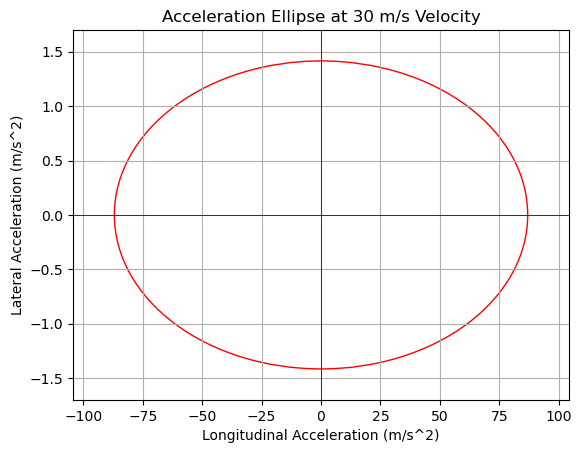

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


# Function to plot an ellipse for a given velocity
def plot_acceleration_ellipse(df, velocity):
    # Filter the row for the given velocity
    row = df[df['Velocity'] == velocity]

    if not row.empty:
        max_acc_lat = row['MaxAccLat'].values[0]
        max_acc_long = row['MaxAccLong'].values[0]

        # Plotting the ellipse
        fig, ax = plt.subplots()
        ellipse = Ellipse((0, 0), width=2*max_acc_long, height=2*max_acc_lat, edgecolor='r', facecolor='none')

        # Adding the ellipse to the plot
        ax.add_patch(ellipse)

        # Setting limits and labels for clarity
        plt.xlim(-max_acc_long*1.2, max_acc_long*1.2)
        plt.ylim(-max_acc_lat*1.2, max_acc_lat*1.2)
        plt.axhline(0, color='black',linewidth=0.5)
        plt.axvline(0, color='black',linewidth=0.5)
        plt.xlabel('Longitudinal Acceleration (m/s^2)')
        plt.ylabel('Lateral Acceleration (m/s^2)')
        plt.title(f'Acceleration Ellipse at {velocity} m/s Velocity')
        plt.grid(True)
        plt.show()
    else:
        print(f"No data found for velocity: {velocity} m/s")

# Example usage: Plot ellipse for a given velocity
plot_acceleration_ellipse(df_joined, 30)  # Change 30 to your specific velocity of interest


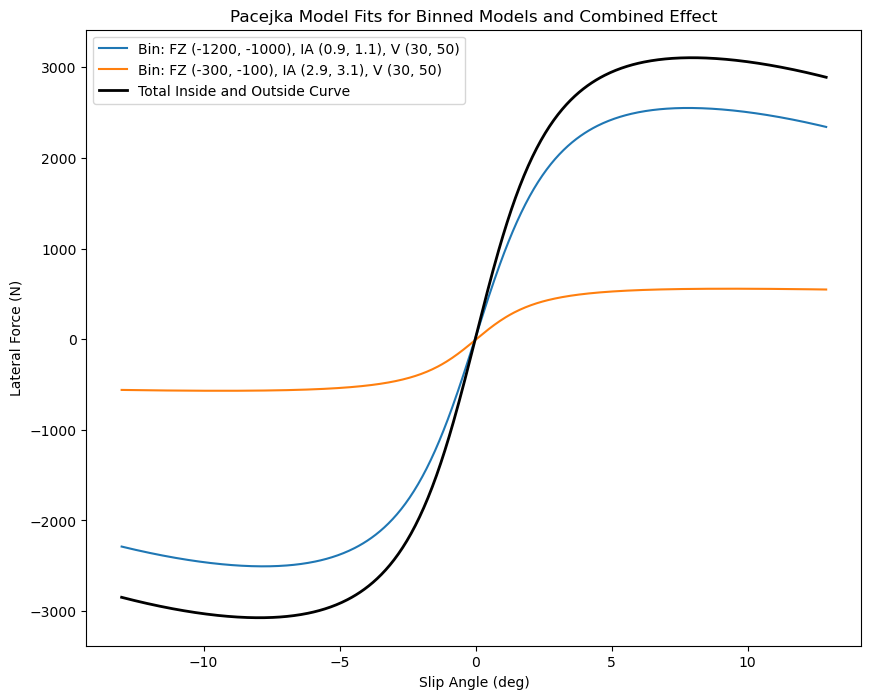

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load and clean the data
data_path = r'/Users/nicholaslemoff/Desktop/FEBSim/TireSim/tirecsvfiles/B1320run52.csv'
data = pd.read_csv(data_path)
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['FY', 'SA', 'FZ', 'IA', 'V'], inplace=True)

# Define bins with specific ranges
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1), 'v_range': (30, 50)},
    {'fz_range': (-300, -100), 'ia_range': (2.9, 3.1), 'v_range': (30, 50)}
]
model_params = []

# Fit model for each bin
for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1]) &
        (data['V'] >= bin_info['v_range'][0]) & (data['V'] <= bin_info['v_range'][1])
        ]
    x_data = filtered_data['SA']
    y_data = filtered_data['FY']
    if not x_data.empty and not y_data.empty:
        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        optimal_parameters, _ = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
        model_params.append((bin_info, optimal_parameters))

# Prepare to plot
fig, ax = plt.subplots(figsize=(10, 8))
x_model = np.linspace(min(data['SA']), max(data['SA']), 500)

# Compute and plot individual curves and add to total curve
y_total_model = np.zeros_like(x_model)
labels_added = []

for bin_info, params in model_params:
    y_model = pacejka_model(x_model, *params)
    y_total_model += y_model  # Sum up contributions
    label = f'Bin: FZ {bin_info["fz_range"]}, IA {bin_info["ia_range"]}, V {bin_info["v_range"]}'
    ax.plot(x_model, y_model, label=label)
    labels_added.append(label)

# Plot the total curve
ax.plot(x_model, y_total_model, color='black', linestyle='-', linewidth=2, label='Total Inside and Outside Curve')
ax.set_title('Pacejka Model Fits for Binned Models and Combined Effect')
ax.set_xlabel('Slip Angle (deg)')
ax.set_ylabel('Lateral Force (N)')
ax.legend()

plt.show()


In [18]:
data['V'].sort_values(ascending=True)

26128    -0.04
26122    -0.04
26131    -0.03
26130    -0.03
26129    -0.03
         ...  
24968    40.59
24002    40.60
24966    40.60
24967    40.60
24003    40.61
Name: V, Length: 26131, dtype: float64

In [92]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load and clean the data
data_path = r'/Users/nicholaslemoff/Desktop/FEBSim/TireSim/tirecsvfiles/B1320run52.csv'
data = pd.read_csv(data_path)
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['FY', 'SA', 'FZ', 'IA', 'V'], inplace=True)

# Define bins with specific ranges
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1)}
    #{'fz_range': (-300, -100), 'ia_range': (2.9, 3.1)}
]
model_params = []

# Fit model for each bin
for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1])
        ]
    x_data = filtered_data['SA']
    y_data = filtered_data['FY']
    if not x_data.empty and not y_data.empty:
        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        optimal_parameters, _ = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
        model_params.append((bin_info, optimal_parameters))

# Define mass in kg
mass = 341  # kg

# Create dictionary to store results
lateral_results_dict = {}

# Iterate over velocities from 0 to 42 with increments of 0.05
velocities = np.arange(0, 50, 0.05)
for velocity in velocities:
    total_lateral_acceleration = 0
    for _, params in model_params:
        # Calculate lateral force for each bin at the specified velocity
        lateral_force = pacejka_model(0, *params)  # Use 0 slip angle for maximum lateral grip
        # Calculate lateral acceleration using Newton's second law (F = ma)
        lateral_acceleration = lateral_force / mass
        # Multiply by velocity to account for velocity-dependent forces
        total_lateral_acceleration += lateral_acceleration * velocity
    lateral_results_dict[round(velocity, 2)] = total_lateral_acceleration

print(lateral_results_dict)


{0.0: 0.0, 0.05: 0.0032701172785940496, 0.1: 0.006540234557188099, 0.15: 0.00981035183578215, 0.2: 0.013080469114376199, 0.25: 0.016350586392970247, 0.3: 0.0196207036715643, 0.35: 0.022890820950158347, 0.4: 0.026160938228752397, 0.45: 0.029431055507346444, 0.5: 0.032701172785940494, 0.55: 0.03597129006453455, 0.6: 0.0392414073431286, 0.65: 0.04251152462172264, 0.7: 0.045781641900316694, 0.75: 0.04905175917891074, 0.8: 0.052321876457504794, 0.85: 0.05559199373609885, 0.9: 0.05886211101469289, 0.95: 0.06213222829328694, 1.0: 0.06540234557188099, 1.05: 0.06867246285047504, 1.1: 0.0719425801290691, 1.15: 0.07521269740766315, 1.2: 0.0784828146862572, 1.25: 0.08175293196485123, 1.3: 0.08502304924344528, 1.35: 0.08829316652203933, 1.4: 0.09156328380063339, 1.45: 0.09483340107922744, 1.5: 0.09810351835782148, 1.55: 0.10137363563641553, 1.6: 0.10464375291500959, 1.65: 0.10791387019360364, 1.7: 0.1111839874721977, 1.75: 0.11445410475079174, 1.8: 0.11772422202938577, 1.85: 0.12099433930797983, 1.

In [90]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load and clean the data
data_path = r'/Users/nicholaslemoff/Desktop/FEBSim/TireSim/tirecsvfiles/B1320run51.csv'
data = pd.read_csv(data_path)
data['FX'] = pd.to_numeric(data['FX'], errors='coerce') * -1
data['SR'] = pd.to_numeric(data['SR'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['FX', 'SR', 'FZ', 'IA', 'V'], inplace=True)

# Define bins with specific ranges
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1)}
    #{'fz_range': (-300, -100), 'ia_range': (2.9, 3.1)}
]
model_params = []

# Fit model for each bin
for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1])
        ]
    x_data = filtered_data['SR']
    y_data = filtered_data['FX']
    if not x_data.empty and not y_data.empty:
        initial_guess = [0.75, 1.2, max(data['FX']), 1, 0]
        optimal_parameters, _ = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
        model_params.append((bin_info, optimal_parameters))

# Define mass in kg
mass = 341  # kg

# Create dictionary to store results
longitudinal_results_dict = {}

# Iterate over velocities from 0 to 42 with increments of 0.05
velocities = np.arange(0, 50, 0.05)
for velocity in velocities:
    total_lateral_acceleration = 0
    for _, params in model_params:
        # Calculate lateral force for each bin at the specified velocity and sum up
        lateral_force = pacejka_model(0, *params) * velocity  # Use 0 slip angle for maximum lateral grip
        lateral_acceleration = lateral_force / mass  # Calculate lateral acceleration using Newton's second law
        total_lateral_acceleration += lateral_acceleration
    longitudinal_results_dict[round(velocity, 2)] = total_lateral_acceleration

print(longitudinal_results_dict)


{0.0: 0.0, 0.05: 0.04837397967961101, 0.1: 0.09674795935922202, 0.15: 0.14512193903883305, 0.2: 0.19349591871844404, 0.25: 0.24186989839805506, 0.3: 0.2902438780776661, 0.35: 0.3386178577572771, 0.4: 0.3869918374368881, 0.45: 0.4353658171164991, 0.5: 0.4837397967961101, 0.55: 0.5321137764757211, 0.6: 0.5804877561553322, 0.65: 0.6288617358349432, 0.7: 0.6772357155145542, 0.75: 0.7256096951941651, 0.8: 0.7739836748737762, 0.85: 0.8223576545533873, 0.9: 0.8707316342329982, 0.95: 0.9191056139126091, 1.0: 0.9674795935922202, 1.05: 1.0158535732718312, 1.1: 1.0642275529514422, 1.15: 1.1126015326310534, 1.2: 1.1609755123106644, 1.25: 1.2093494919902752, 1.3: 1.2577234716698864, 1.35: 1.3060974513494974, 1.4: 1.3544714310291084, 1.45: 1.4028454107087196, 1.5: 1.4512193903883301, 1.55: 1.4995933700679414, 1.6: 1.5479673497475523, 1.65: 1.5963413294271636, 1.7: 1.6447153091067745, 1.75: 1.6930892887863853, 1.8: 1.7414632684659963, 1.85: 1.7898372481456073, 1.9: 1.8382112278252183, 1.95: 1.8865852

In [91]:
df_lat = pd.DataFrame(list(lateral_results_dict.items()), columns=['Velocity', 'MaxAccLat'])
df_long = pd.DataFrame(list(longitudinal_results_dict.items()), columns=['Velocity', 'MaxAccLong'])

# Merge the DataFrames on the 'Velocity' column
df_joined = pd.merge(df_lat, df_long, on='Velocity')

# Display the first few rows of the DataFrame
df_joined

,Velocity,MaxAccLat,MaxAccLong
0,0.00,0.000000,0.000000
1,0.05,0.003270,0.048374
2,0.10,0.006540,0.096748
3,0.15,0.009810,0.145122
4,0.20,0.013080,0.193496
...,...,...,...
995,49.75,3.253767,48.132110
996,49.80,3.257037,48.180484
997,49.85,3.260307,48.228858
998,49.90,3.263577,48.277232


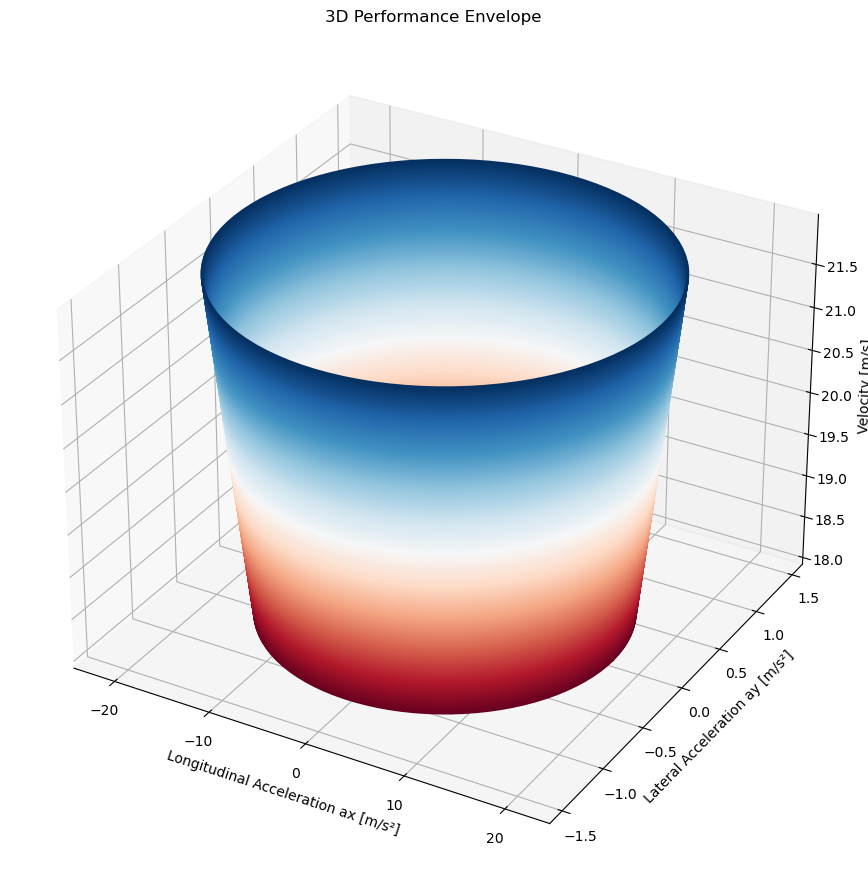

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

# Intersect the keys (velocities) in both dictionaries
common_velocities = sorted(set(longitudinal_results_dict).intersection(lateral_results_dict))

# Setup the figure and axes for 3D plotting
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')

# Loop over each common velocity and create an ellipse
for i, velocity in enumerate(common_velocities):
    ax_max = longitudinal_results_dict[velocity]  # Longitudinal acceleration
    ay_max = lateral_results_dict[velocity]   # Lateral acceleration

    # Ellipse parameters for the ax and ay accelerations
    theta = np.linspace(0, 2 * np.pi, 100)
    ax_ellipse = ax_max * np.cos(theta)
    ay_ellipse = ay_max * np.sin(theta)

    # Define color based on velocity (gradient from red to blue)
    color = cm.RdBu(i / len(common_velocities))

    # Plot the ellipse for this velocity, centered at 0
    ax.plot(ax_ellipse, ay_ellipse, zs=velocity, zdir='z', color=color)

# Set labels and title
ax.set_xlabel('Longitudinal Acceleration ax [m/s²]')
ax.set_ylabel('Lateral Acceleration ay [m/s²]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title('3D Performance Envelope')

# Show plot
plt.show()


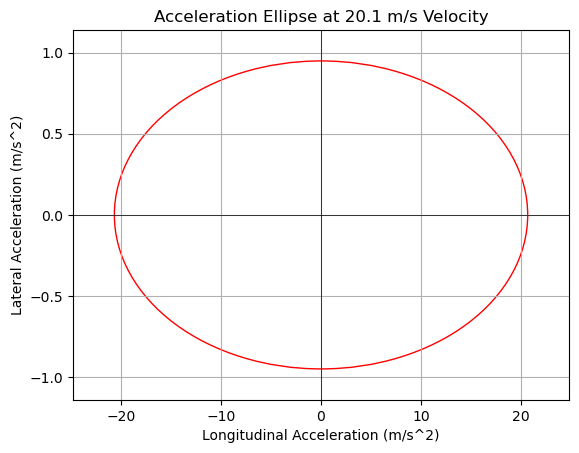

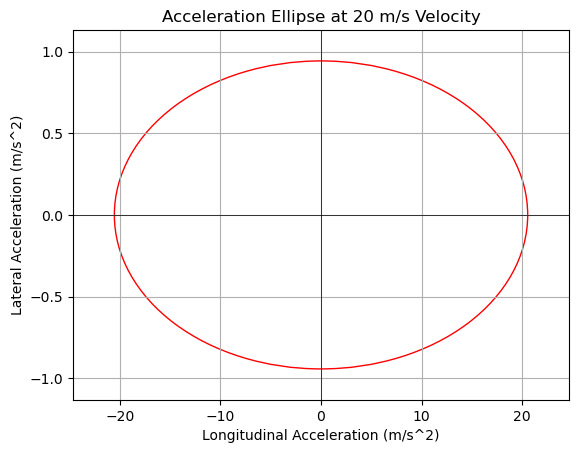

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


# Function to plot an ellipse for a given velocity
def plot_acceleration_ellipse(df, velocity):
    # Filter the row for the given velocity
    row = df[df['Velocity'] == velocity]

    if not row.empty:
        max_acc_lat = row['MaxAccLat'].values[0]
        max_acc_long = row['MaxAccLong'].values[0]

        # Plotting the ellipse
        fig, ax = plt.subplots()
        ellipse = Ellipse((0, 0), width=2*max_acc_long, height=2*max_acc_lat, edgecolor='r', facecolor='none')

        # Adding the ellipse to the plot
        ax.add_patch(ellipse)

        # Setting limits and labels for clarity
        plt.xlim(-max_acc_long*1.2, max_acc_long*1.2)
        plt.ylim(-max_acc_lat*1.2, max_acc_lat*1.2)
        plt.axhline(0, color='black',linewidth=0.5)
        plt.axvline(0, color='black',linewidth=0.5)
        plt.xlabel('Longitudinal Acceleration (m/s^2)')
        plt.ylabel('Lateral Acceleration (m/s^2)')
        plt.title(f'Acceleration Ellipse at {velocity} m/s Velocity')
        plt.grid(True)
        plt.show()
    else:
        print(f"No data found for velocity: {velocity} m/s")

# Example usage: Plot ellipse for a given velocity
plot_acceleration_ellipse(df_joined, 20.1)  # Change 30 to your specific velocity of interest
plot_acceleration_ellipse(df_joined, 20)  # Change 30 to your specific velocity of interest
